## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import rc
import math

## Constants

In [44]:
DIR = "/mnt/perkinsdata/tongue_STOmics/benchmarking/25_2k_4"
FILE = "accuracy.csv"

MEASURES = [("tf", "Recall"), ("tf", "Precision"), ("ft", "Entropy_wo")]
ALGOS = ["Watershed", "Cellpose", "DeepCell"]

In [45]:
# make output dir
OUTPUT = os.path.join(DIR, "plots")
!mkdir $OUTPUT

mkdir: cannot create directory ‘/mnt/perkinsdata/tongue_STOmics/benchmarking/25_2k_4/plots’: File exists


In [52]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], "size": 14})
rc('text', usetex=True)


## Load Data

In [47]:
data = pd.read_csv(os.path.join(DIR, FILE))

In [50]:
# get plotting data from data
means = []
stds = []
for m in MEASURES:
    means.append(list(data[data["TF_FT"] == m[0]][m[1] + "_m"]))
    stds.append(list(data[data["TF_FT"] == m[0]][m[1] + "_s"]))
X = np.arange(3)

## Plotting

In [61]:
OUTPUT

'/mnt/perkinsdata/tongue_STOmics/benchmarking/25_2k_4/plots'

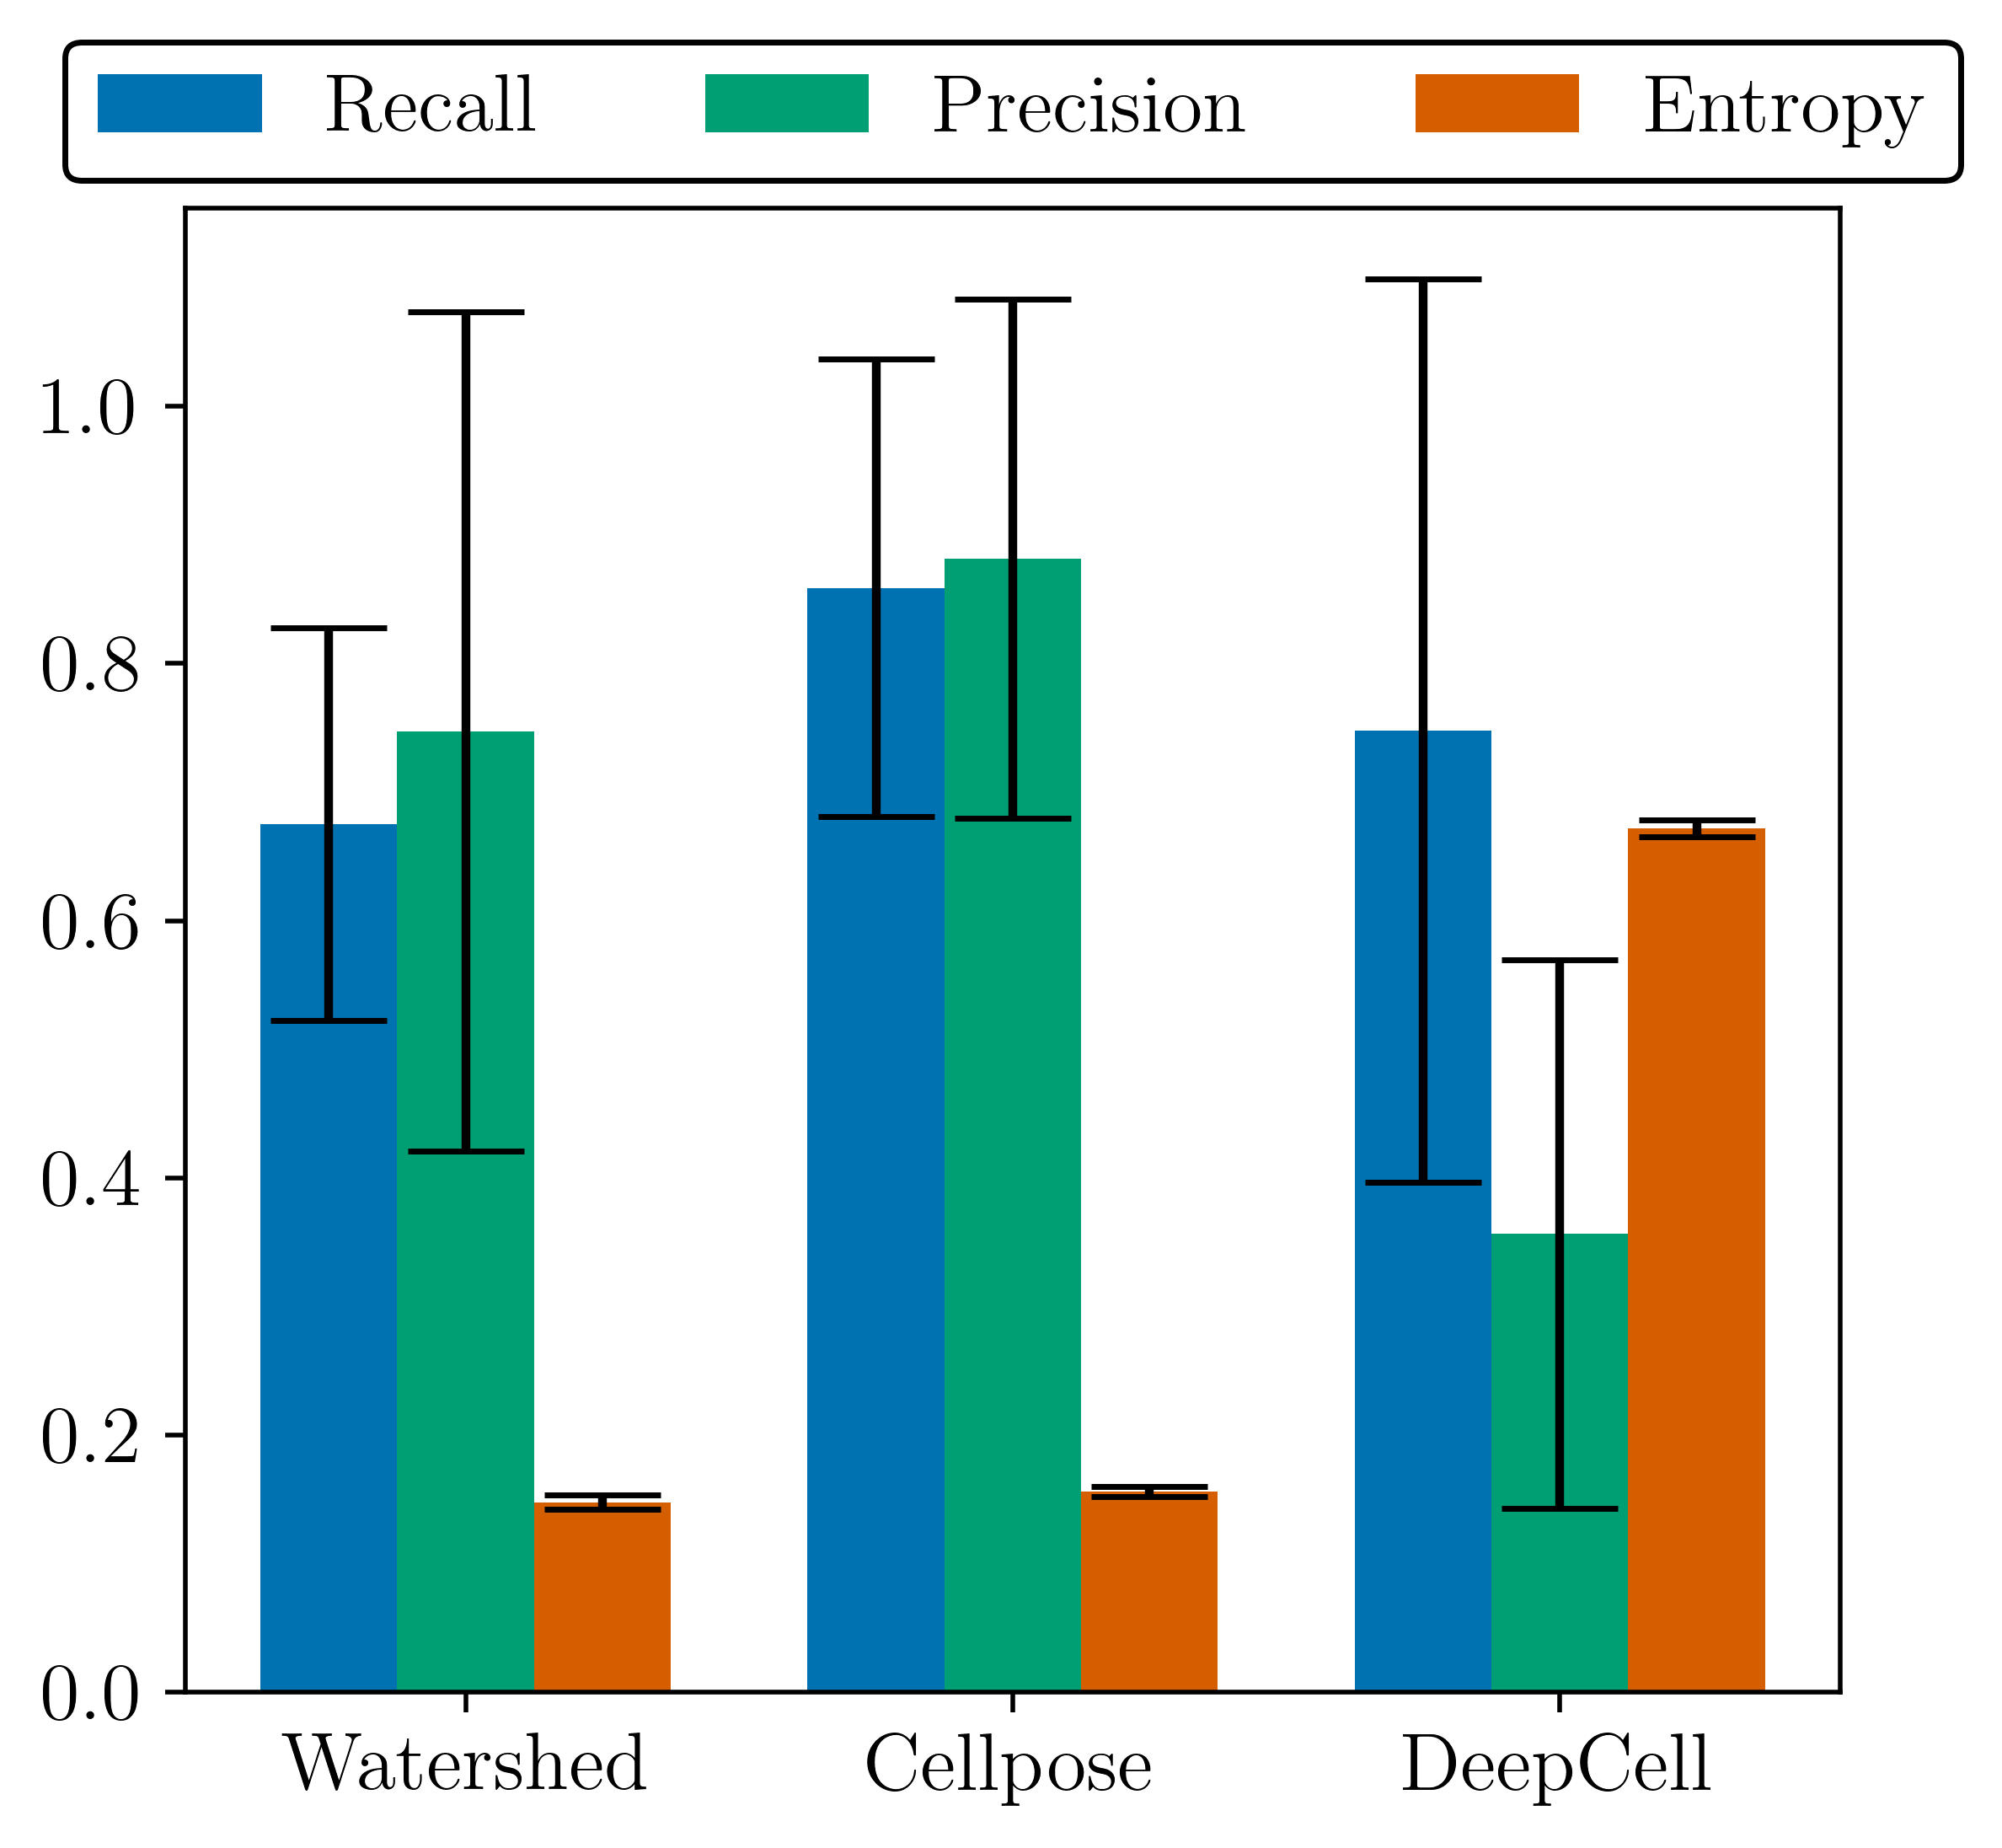

In [77]:
fig, ax = plt.subplots()
legend_above = True

# set colour style
plt.style.use('seaborn-colorblind')

# set white background
fig.patch.set_facecolor('white')
#plt.rcParams["font.weight"] = "bold"
# set im size
fig.set_size_inches(5, 4.6)
fig.set_dpi(500)

# add bar plots
ax.bar(X + 0.00, means[0], yerr=stds[0], align='center', capsize=10, width = 0.25)
ax.bar(X + 0.25, means[1], yerr=stds[1], align='center', capsize=10, width = 0.25)
ax.bar(X + 0.50, means[2], yerr=stds[2], align='center', capsize=10, width = 0.25)

#ax.set_ylabel('Accuracy Measure')
ax.set_xticks(X+0.25)
ax.set_xticklabels(ALGOS)
#ax.set_title('Recall, Precision, and Entropy on Synthetic Images')
ax.yaxis.grid(False)

# legen
if legend_above:
    ax.legend(labels=['Recall', 'Precision', "Entropy"], loc = "upper center", ncol = 3, bbox_to_anchor = (0.5, 1.14), fancybox=True, framealpha=1, edgecolor = "black")
else:
    ax.legend(labels=['Recall', 'Precision', "Entropy"], bbox_to_anchor = (1.2, 1), fancybox=True, framealpha=1, edgecolor = "black")

# Save the figure and show
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT, "x_method.pdf"), dpi = 500, format = "pdf", pad_inches = 0, bbox_inches = "tight")
plt.show()

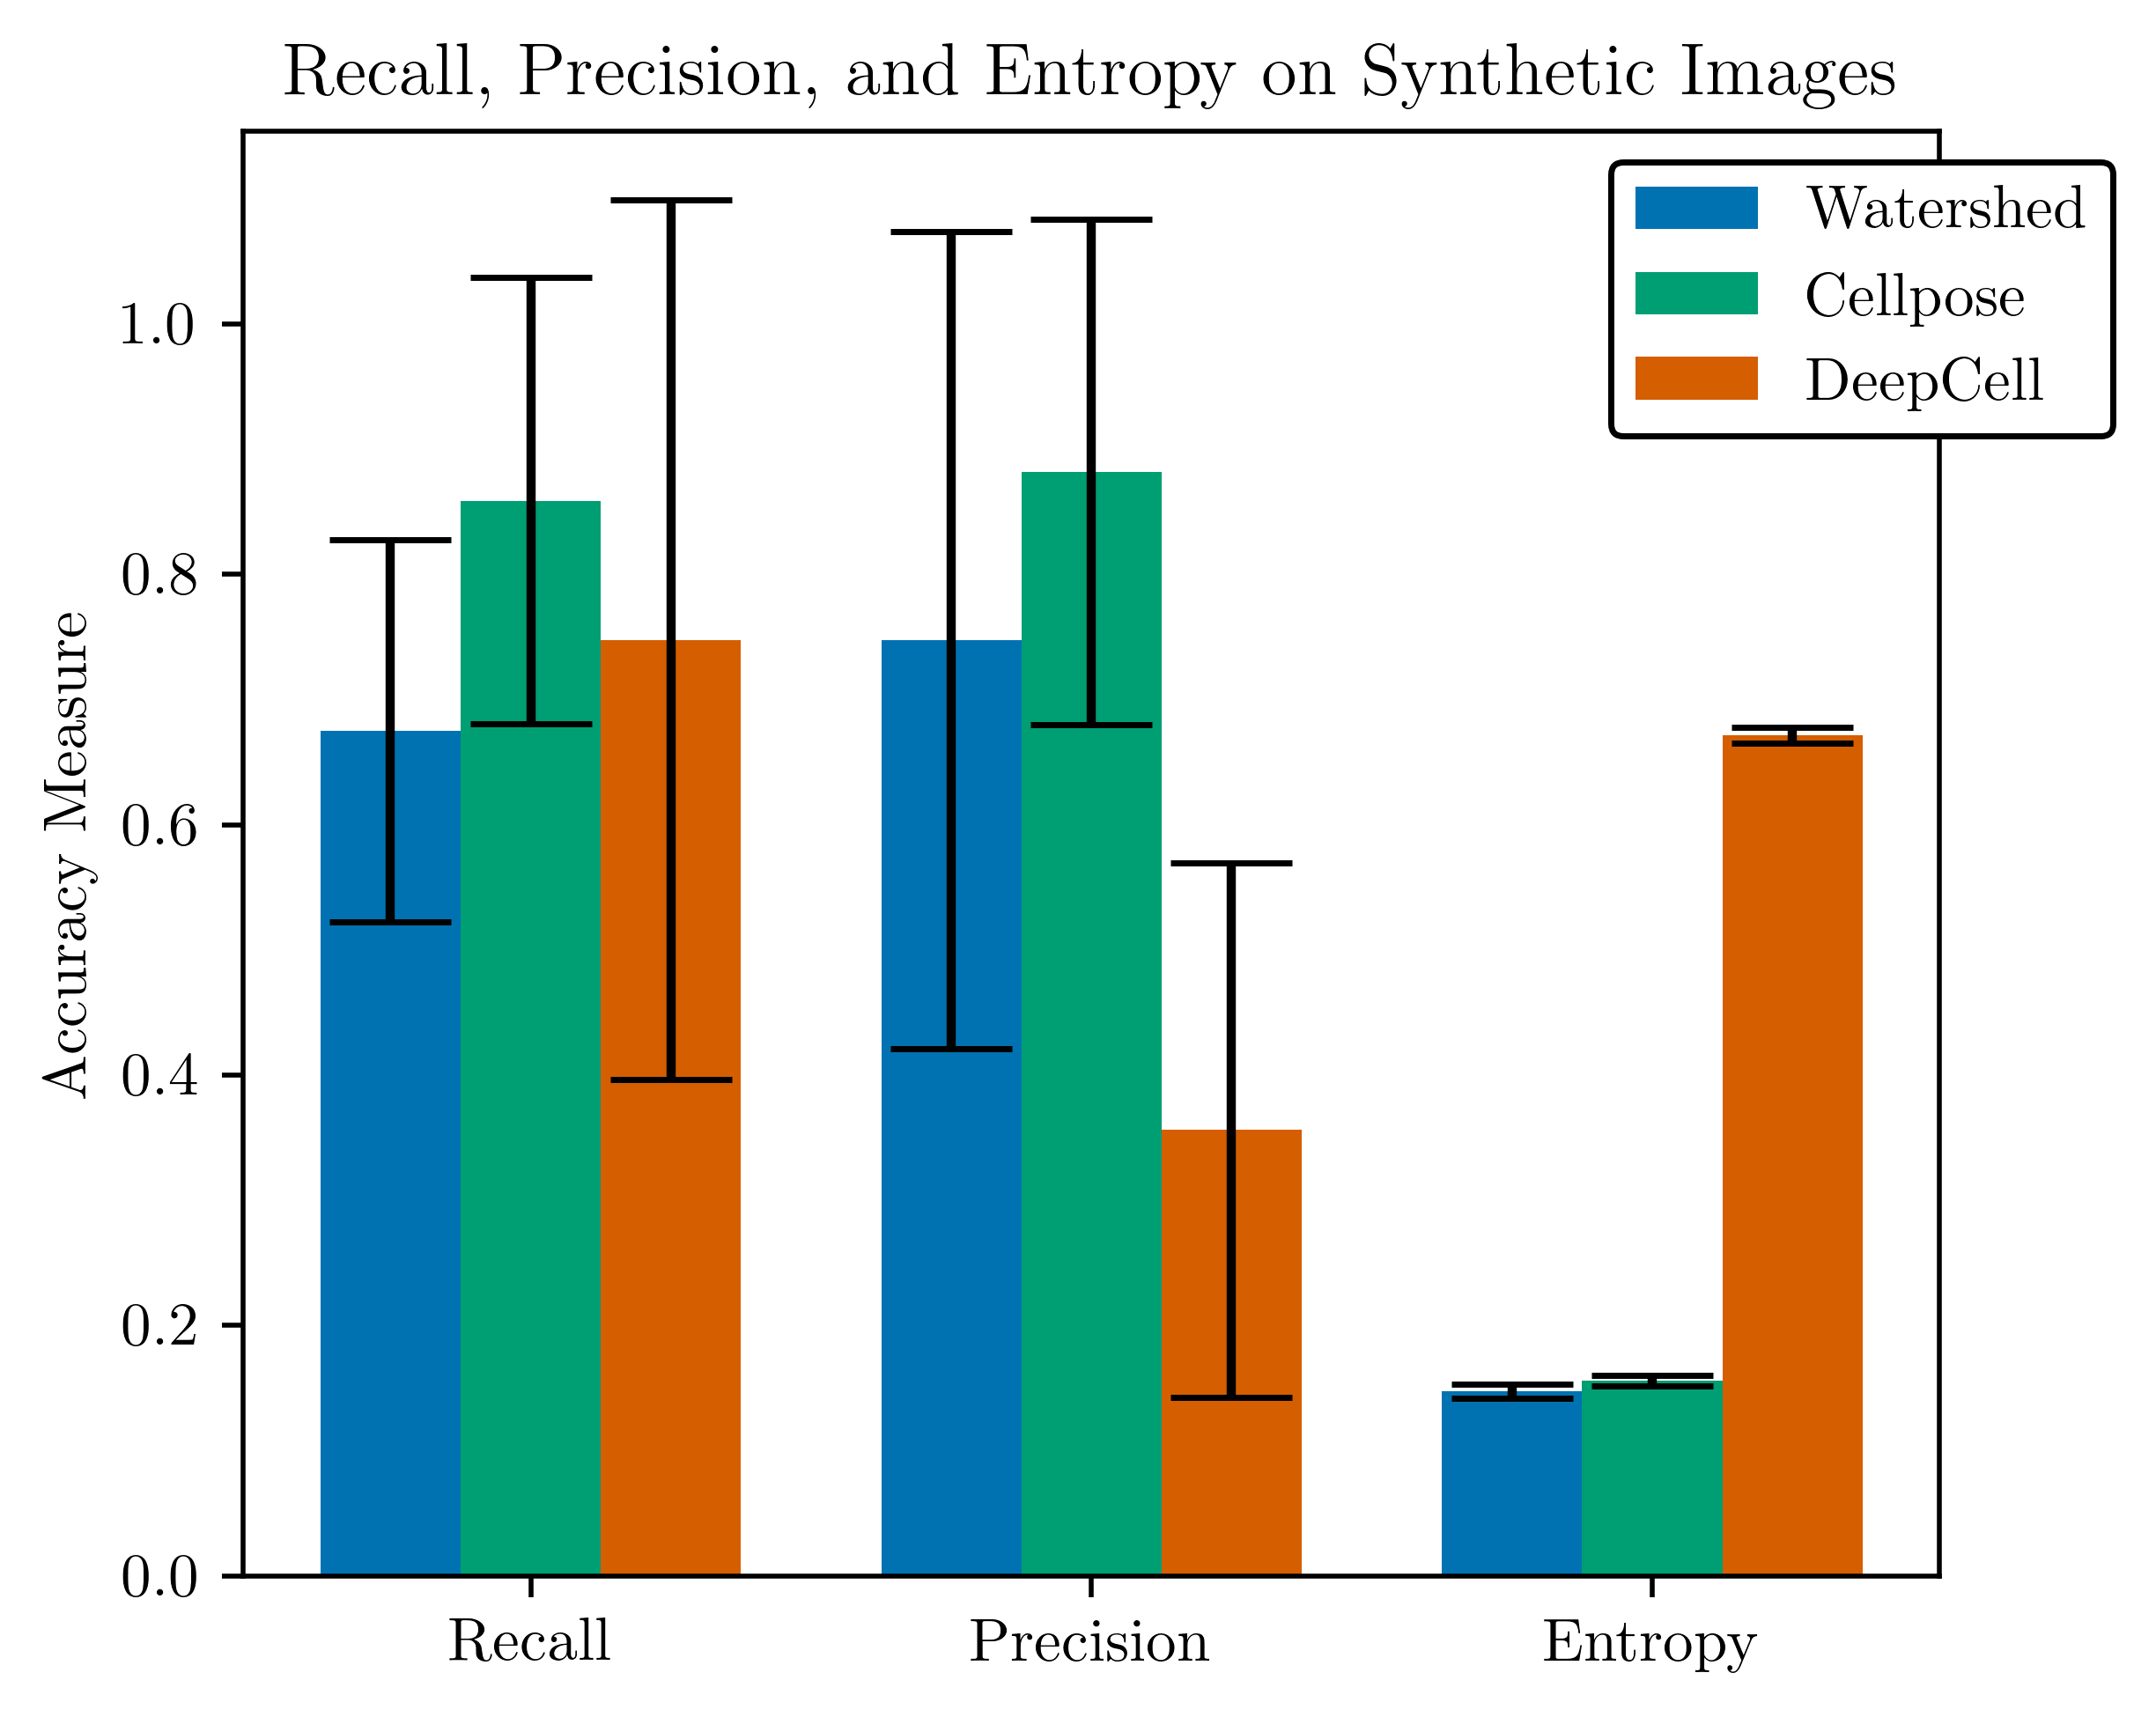

In [87]:


fig, ax = plt.subplots()

# set colour style
plt.style.use('seaborn-colorblind')

# set white background
fig.patch.set_facecolor('white')

# tranpose means and stds
means_t = np.array(means).T
stds_t = np.array(stds).T

# set im size
fig.set_size_inches(5, 4)
fig.set_dpi(500)

# add bar plots
ax.bar(X + 0.00, means_t[0], yerr=stds_t[0], align='center', capsize=10, width = 0.25)
ax.bar(X + 0.25, means_t[1], yerr=stds_t[1], align='center', capsize=10, width = 0.25)
ax.bar(X + 0.50, means_t[2], yerr=stds_t[2], align='center', capsize=10, width = 0.25)

ax.set_ylabel('Accuracy Measure')
ax.set_xticks(X+0.25)
ax.set_xticklabels(['Recall', 'Precision', "Entropy"])
ax.set_title('Recall, Precision, and Entropy on Synthetic Images')
ax.yaxis.grid(False)

ax.legend(labels=ALGOS, bbox_to_anchor=(1.12, 1), fancybox=True, framealpha=1, edgecolor = "black")

# Save the figure and show
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT, "x_accuracy.pdf"), dpi = 500, format = "pdf", pad_inches = 0, bbox_inches = "tight")
plt.show()

## Creating Images

In [2]:
from PIL import Image, ImageDraw

In [3]:
def dist(pos1, pos2):
    return np.sqrt((pos2[0] - pos1[0])**2 + (pos2[1] - pos1[1])**2)

In [4]:
NUM_SPHERES = 30
SIZE_VAR = 40
SIZE = (1000, 1000)
MEAN_SPHERE_SIZE = 120
SEED = 314

In [5]:
def get_pos_size(num_spheres, size_var, size, mean_sphere_size, seed, nuclei_size_mean, nuclei_size_var):
    if seed is None:
        seed = np.random.randint(0, 2**16-1)
        print(seed)
    np.random.seed(seed)
    pos = []
    i = 0
    while len(pos) < num_spheres and i < num_spheres*5:
        new = np.random.rand(2)*(size[0] - mean_sphere_size - size_var/2)
        new = new.astype(int)
        if len(pos) > 0:
            dists = [dist(a, new) for a in pos]
            if np.min(dists) > mean_sphere_size + size_var/2:
                pos.append(new)
            else: i += 1
        else: pos.append(new)
    if i == num_spheres*5: 
        print("failed")
        return (None,None,None)
    sizes = (np.random.rand(num_spheres, 2)*size_var).astype(int) + mean_sphere_size - size_var / 2
    nuclei_sizes = (np.random.rand(num_spheres, 1)*nuclei_size_var).astype(int)+nuclei_size_mean-nuclei_size_var/2
    return (pos, sizes, nuclei_sizes)

In [160]:
def draw_im(pos, sizes, size, nuclei_sizes, black_outlines = False):
    inside = "#6FB4FF"
    membrane = "#2374CC"
    nuclei = "#985AC4"
    outline = "#0E427B"
    
    outline_width = 7
    
    image = Image.new('RGBA', size)
    draw = ImageDraw.Draw(image)
    
    draw.rectangle((0,0,*size), fill = "white", outline = "white")
    
    for (i, (x,y)) in enumerate(pos):
        if black_outlines: #0AFF08
            draw.ellipse((x-black_outlines, y-black_outlines, 
                          x+sizes[i, 0]+black_outlines, y+sizes[i, 1]+black_outlines), 
                          fill = outline, outline = outline)
            draw.ellipse((x, y, x+sizes[i, 0], y+sizes[i, 1]), fill = inside, outline = membrane)
        else:
            draw.ellipse((x, y, x+sizes[i, 0], y+sizes[i, 1]), fill = membrane, outline = membrane)
            draw.ellipse((x+outline_width, y+outline_width, 
                          x+sizes[i, 0]-outline_width, y+sizes[i, 1]-outline_width), 
                         fill = inside, outline = inside)
        
        draw.ellipse((x+sizes[i, 0]/2-nuclei_sizes[i], y+sizes[i, 1]/2-nuclei_sizes[i], 
                      x+sizes[i, 0]/2+nuclei_sizes[i], y+sizes[i, 1]/2+nuclei_sizes[i]), 
                    fill = nuclei, outline = nuclei)
        
    return image, draw

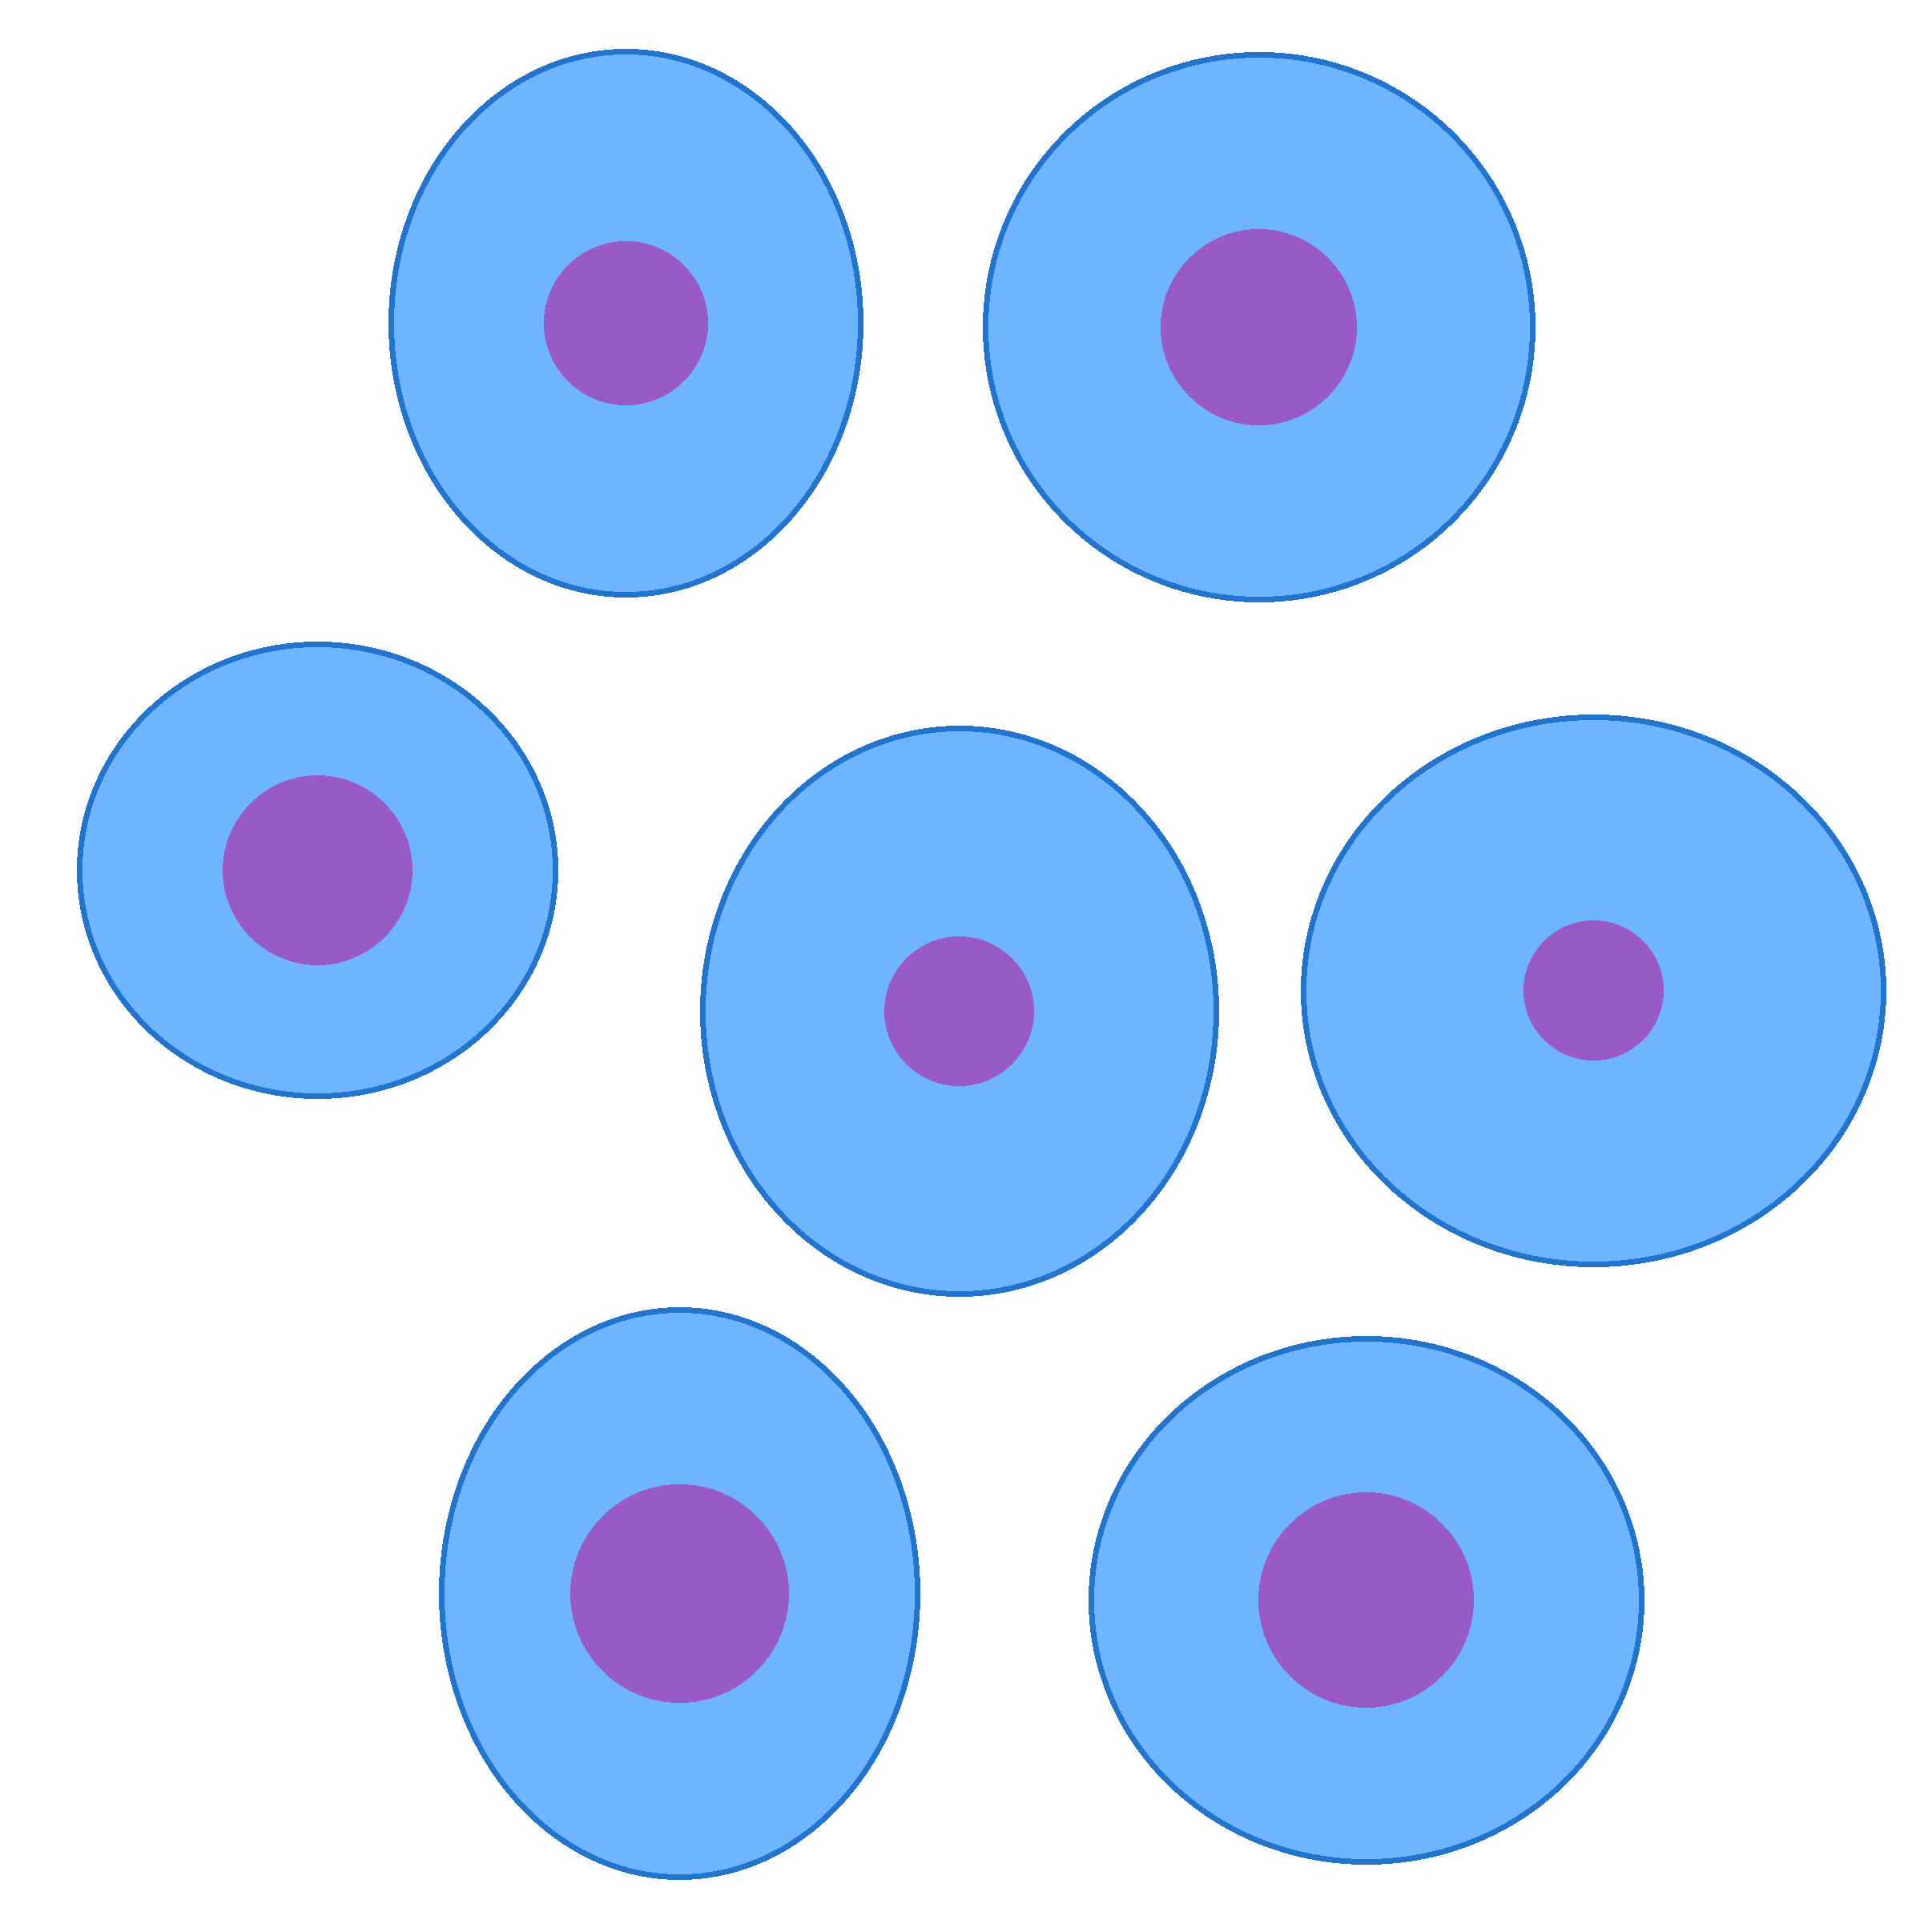

In [161]:
NUM_SPHERES = 7
SIZE_VAR = 100*2
SIZE = (1206*2, 1206*2)
MEAN_SPHERE_SIZE = 320*2
SEED = 23333 #16779 # 65381 # 23333
MEAN_NUCLEI_SIZE = 55*2
NUCLEI_SIZE_VAR = 30*2

pos, sizes, nuclei_sizes = get_pos_size(NUM_SPHERES, SIZE_VAR, SIZE, MEAN_SPHERE_SIZE, SEED, MEAN_NUCLEI_SIZE, NUCLEI_SIZE_VAR)
pos = np.array(pos)
pos[:,1] = pos[:,1]+20*2
#pos = np.array([[150,150], [100,800], [350,500], [500,100], [800,400], [700,800]])
im, draw = draw_im(pos, sizes, SIZE, nuclei_sizes)
#im, draw = draw_spots(im, draw, 10)
im.save("00_tissue.png")
im

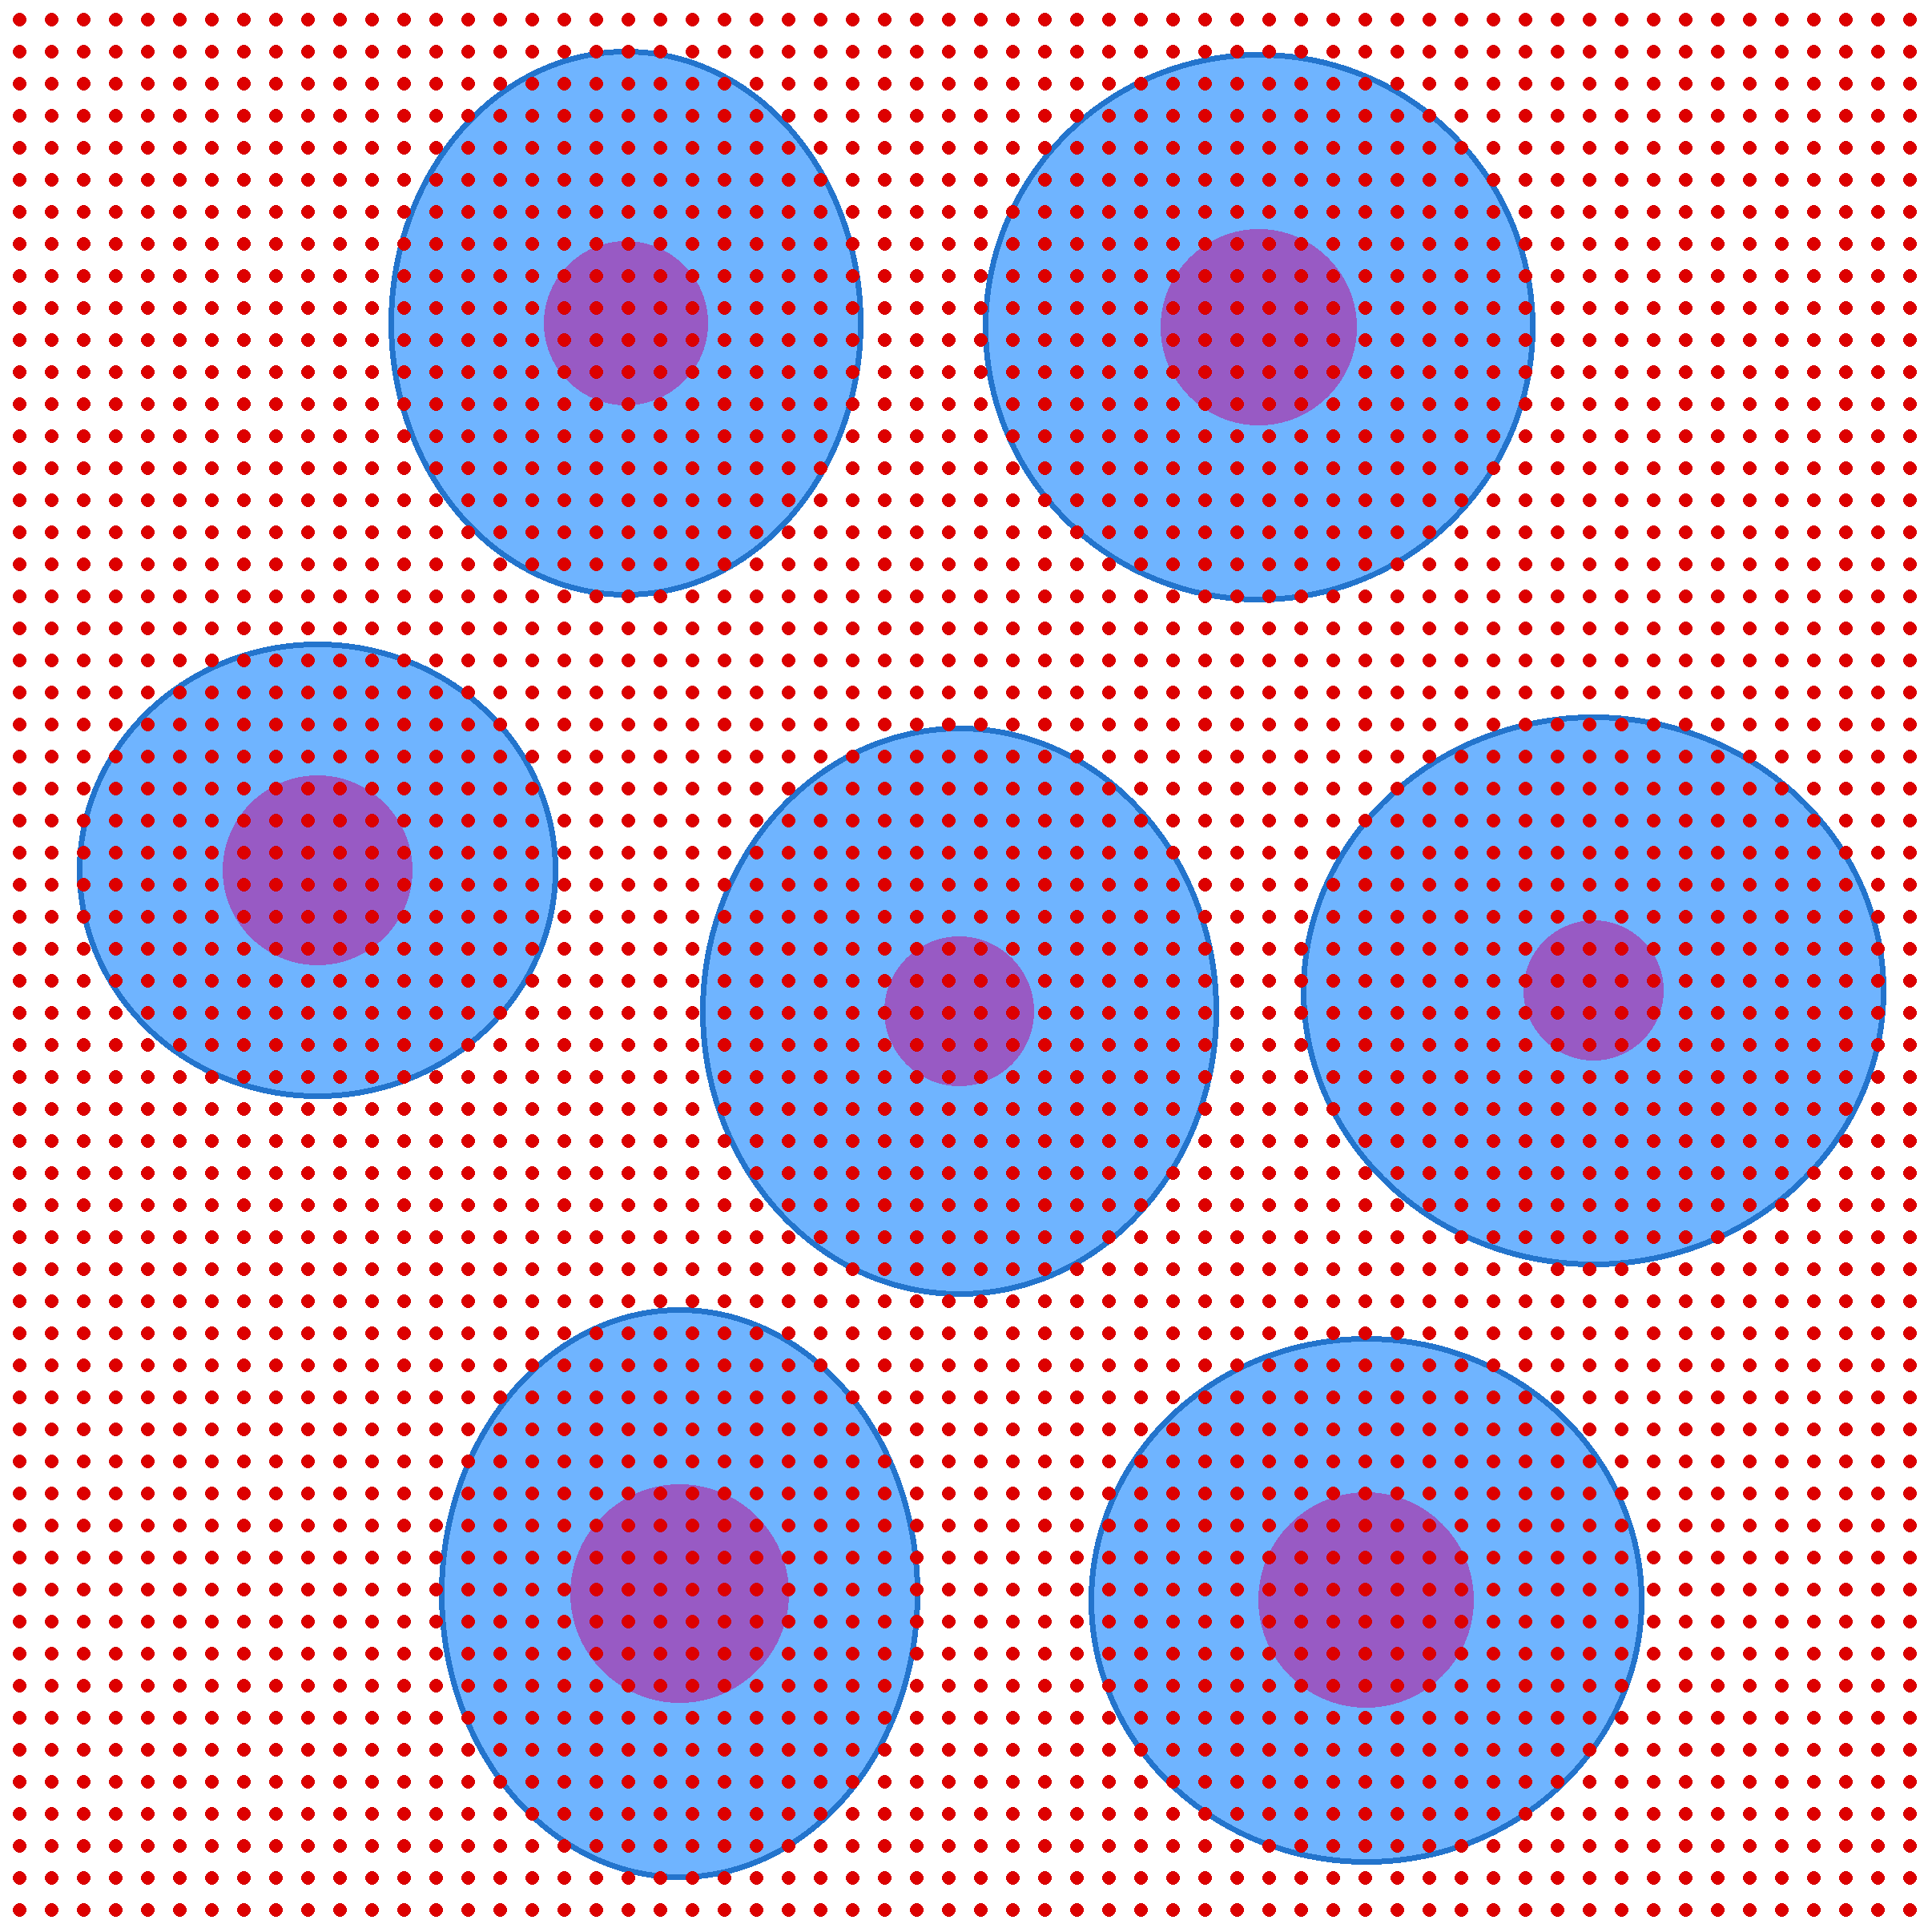

In [162]:
im, draw = draw_im(pos, sizes, SIZE, nuclei_sizes)
im, draw = draw_spots(im, draw, 20*2, diam = 8*2)
im.save("01_on_slide.png")
im

In [158]:
def draw_spots(image, draw, dist: int, filter = False, diam = 1):
    for i in range(int(dist/2)+4, image.size[0], dist):
        for j in range(int(dist/2)+4, image.size[1], dist):
            color_b = image.getpixel((i,j))[:3] != (255,255,255) and image.getpixel((i,j))[:3] != (14,66,123)
            if not filter or color_b:
                draw.ellipse((i-diam//2, j-diam//2, i+math.ceil(diam/2), j+math.ceil(diam/2)), fill = '#DD0000', outline ='#D20000')     
        
    return image, draw

In [13]:
def draw_grids(im, draw, dist: int, width: int):
    for i in range(0, im.size[0], dist):
        for j in range(0, im.size[0], dist):
            for k in range(width):
                draw.rectangle((i+k, j+k, i+dist-1+k, j+dist-1+k), fill = None, outline ='#000000')     
        
    return im,draw

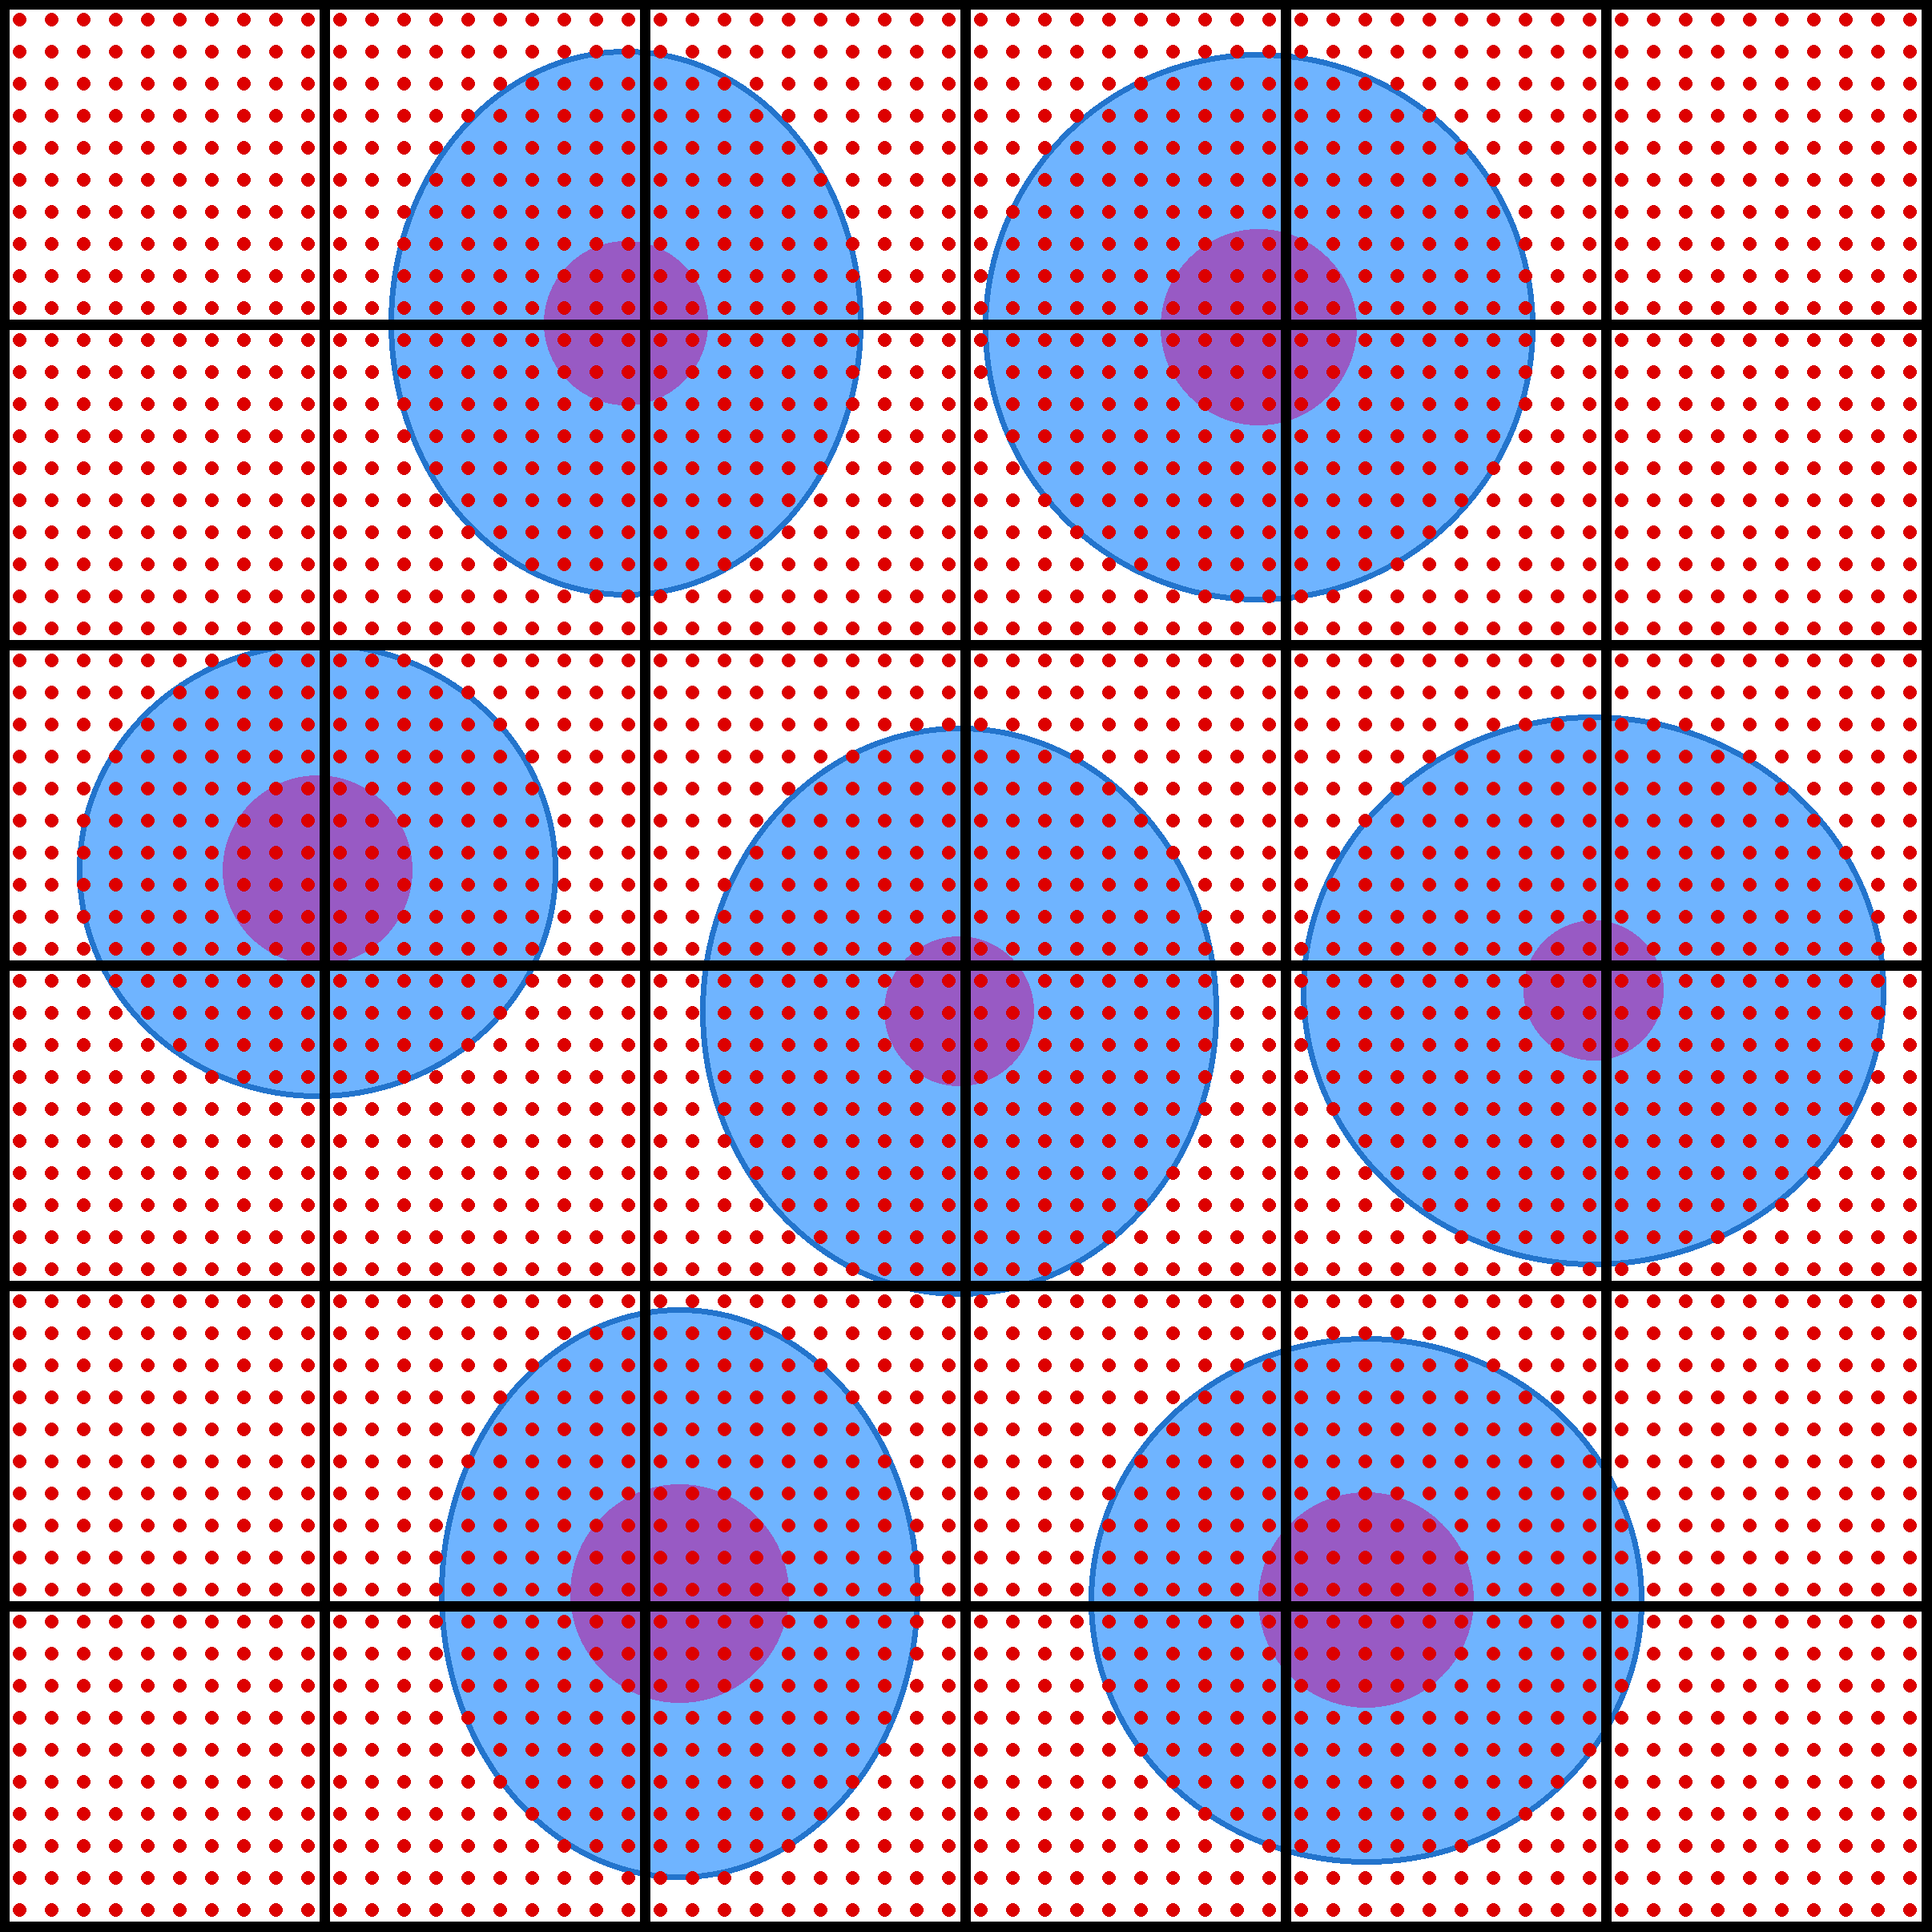

In [163]:
im, draw = draw_im(pos, sizes, SIZE, nuclei_sizes)
im, draw = draw_spots(im, draw, 20*2, diam = 8*2)
im, draw = draw_grids(im, draw, 200*2, 6*2)
im.save("02_binned.png")
im

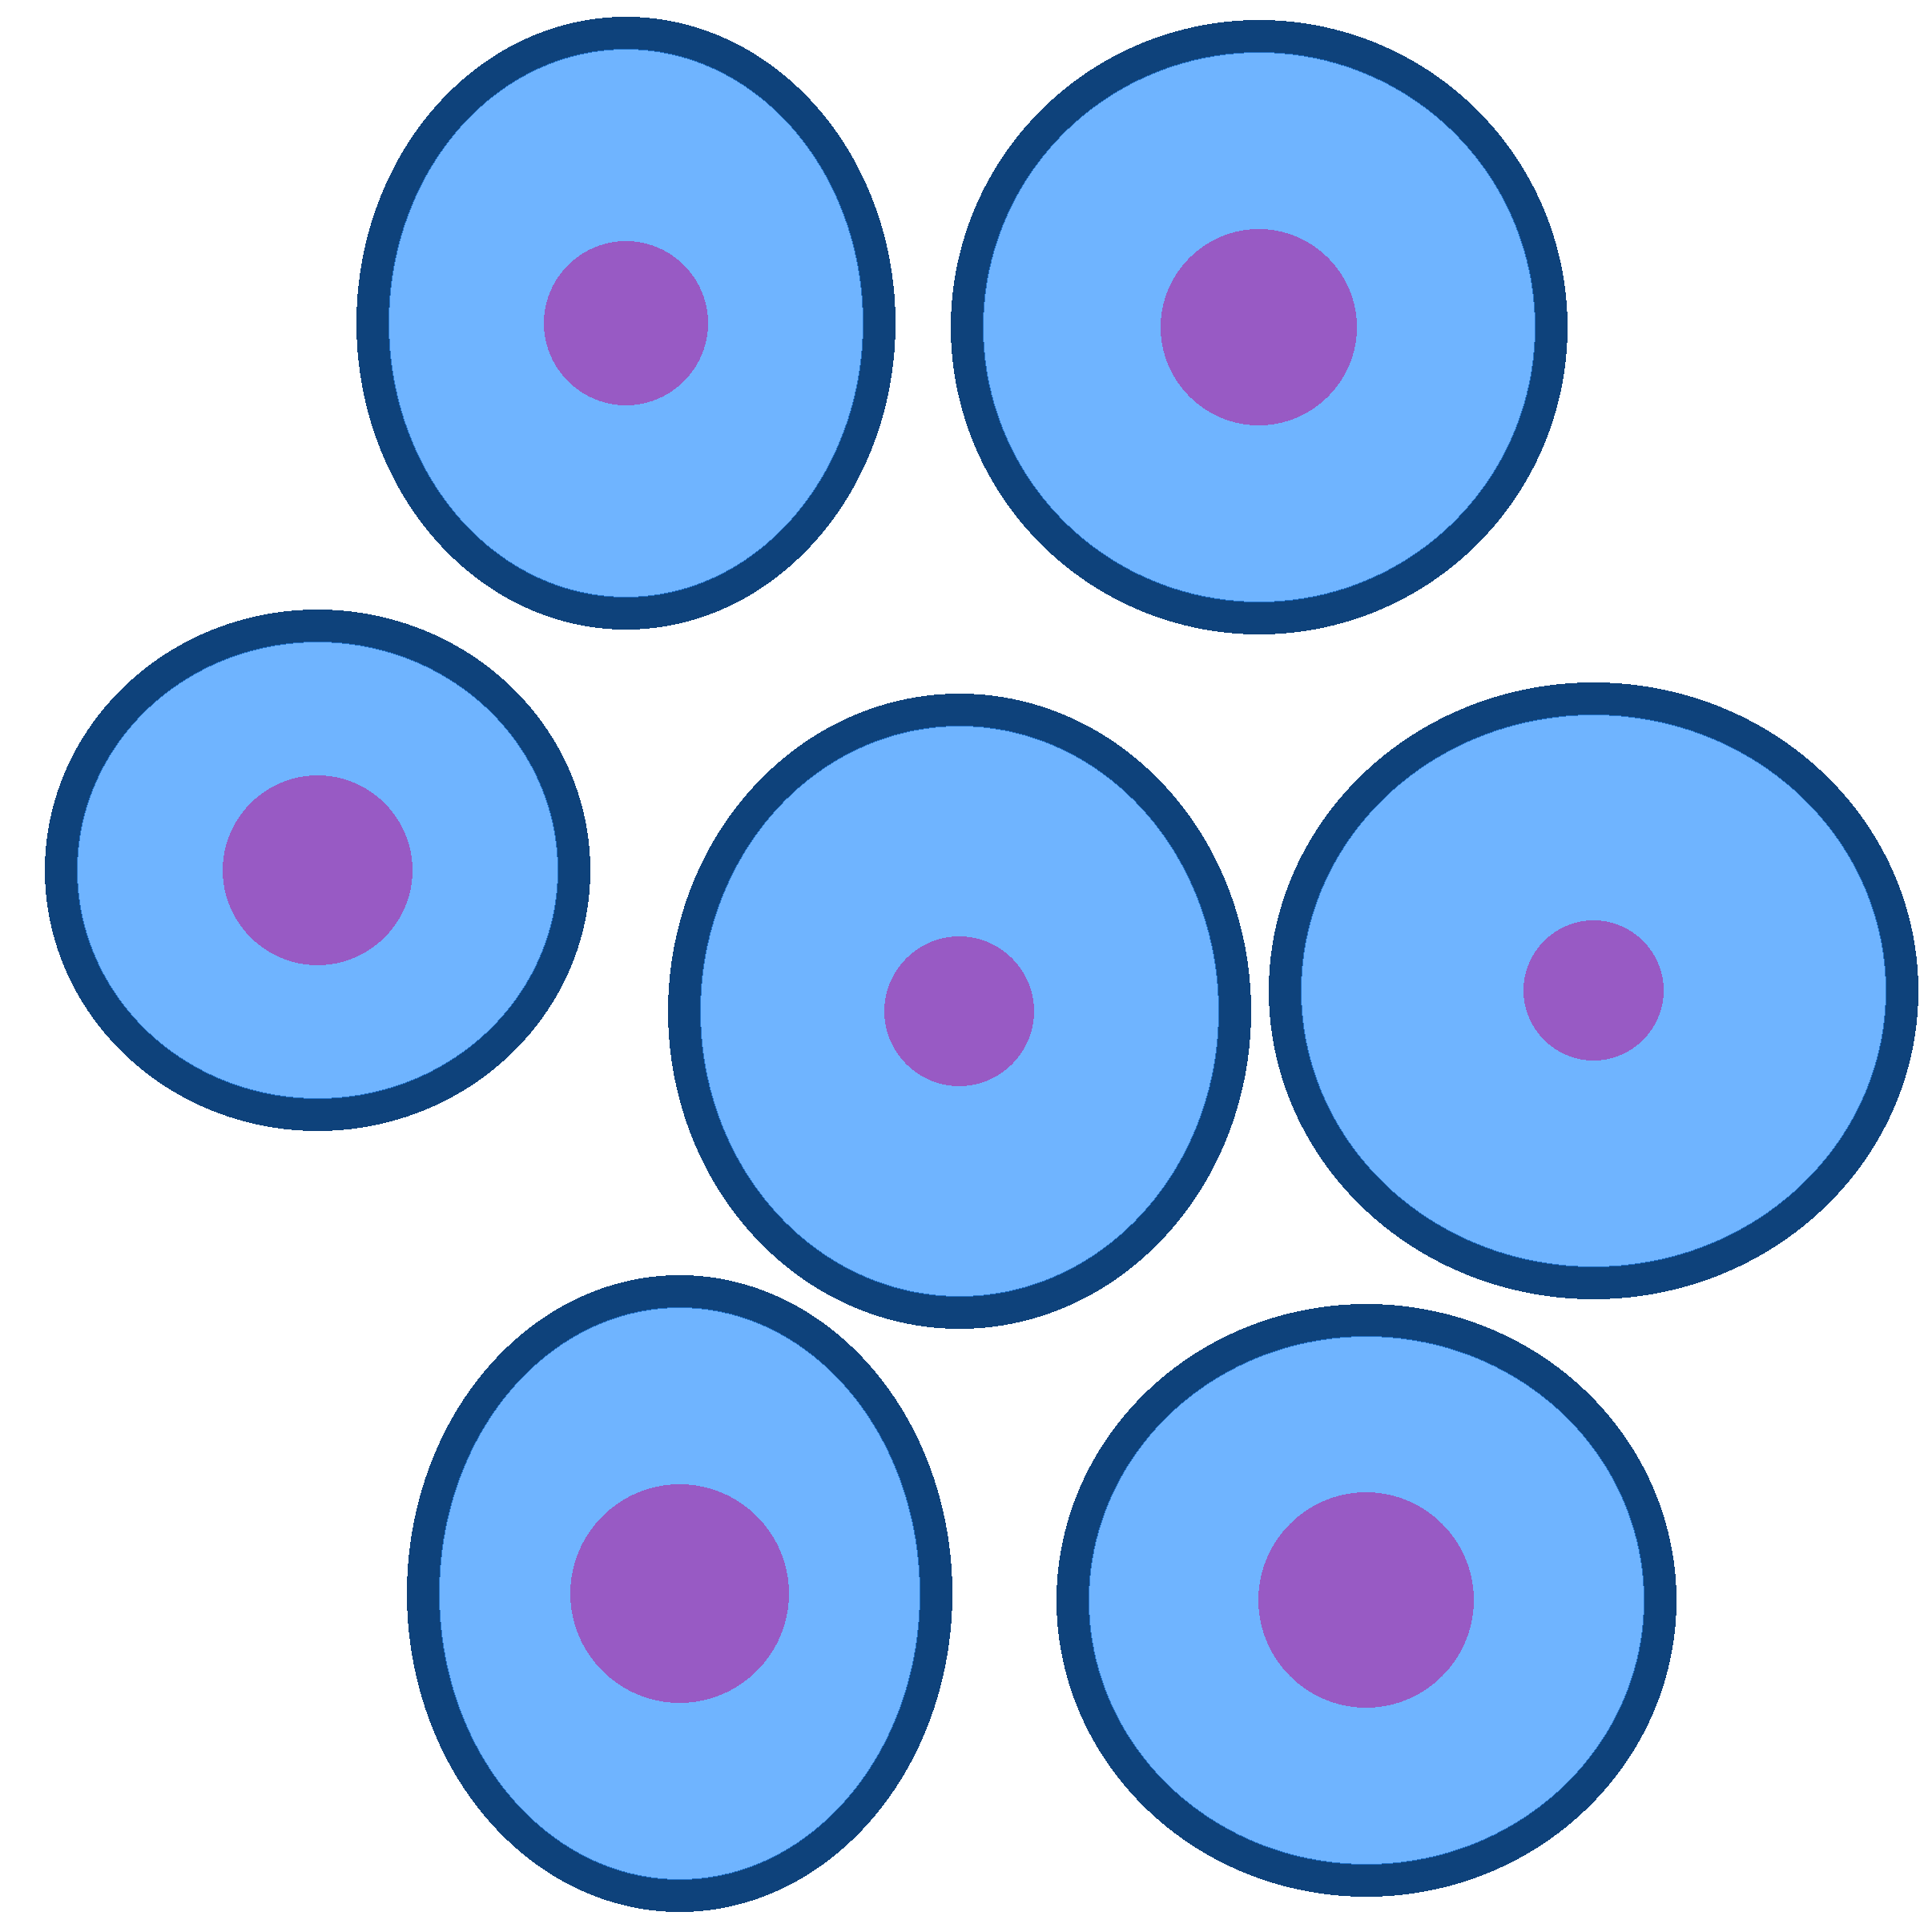

In [167]:
im, draw = draw_im(pos, sizes, SIZE, nuclei_sizes, 40)
#im, draw = draw_spots(im, draw, 20, diam = 6)
im.save("03_segmented.png")
im

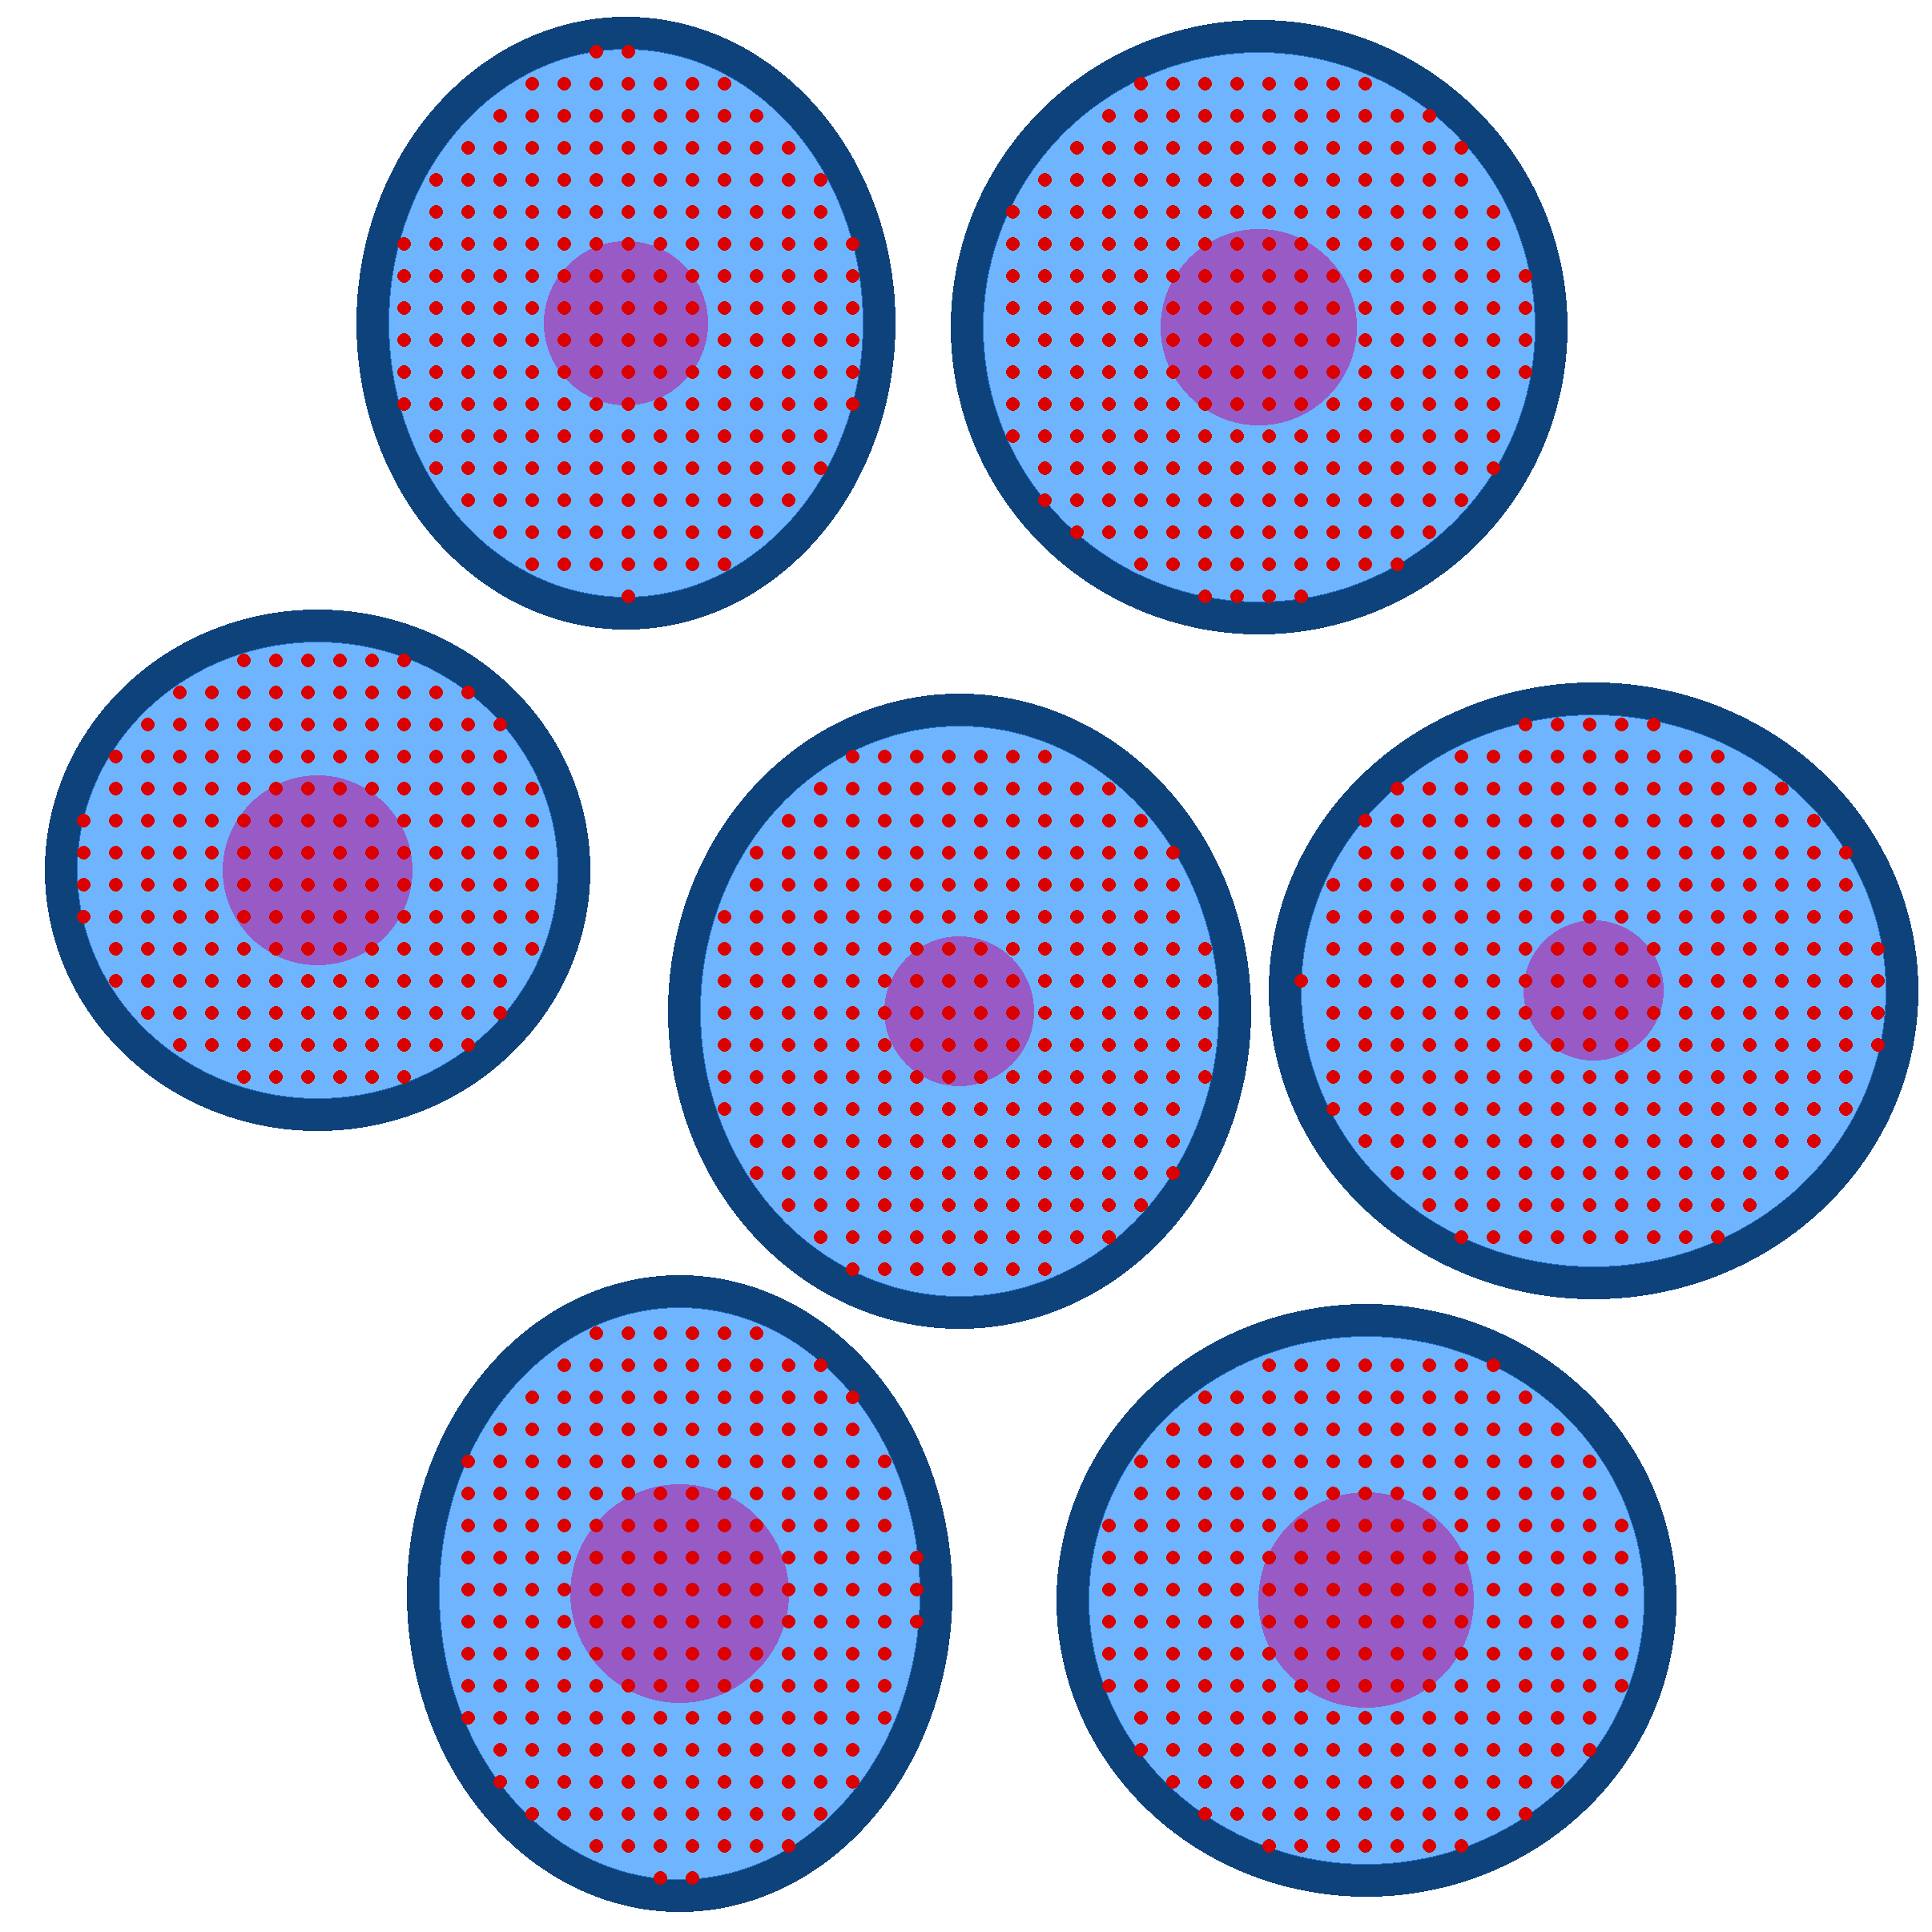

In [166]:
im, draw = draw_im(pos, sizes, SIZE, nuclei_sizes, 40)
im, draw = draw_spots(im, draw, 40, diam = 16, filter = True)
im.save("04_segment_applied.png")
im

In [316]:
im.getpixel((0,0))[:3] != (0,0,0)

False